# Load Data

In [1]:
import numpy as np
import pandas as pd
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
# meta_df = pd.read_csv("metadata.csv")

In [8]:
# if you were to do this individually
# meta_df['pubmed_id'] = meta_df['pubmed_id'].astype(str)


In [2]:
meta_df = pd.read_csv('metadata.csv', dtype ={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str,
    'doi' : str
})

## Fetch All of JSON File Path

In [3]:
ls

COVID.DATA.LIC.AGMT.pdf        custom_license/
README.md                      json_schema.txt
biorxiv_medrxiv/               metadata.csv
comm_use_subset/               metadata.readme
county_date/                   noncomm_use_subset/
covid19_workbook.ipynb         states-daily.csv
covid_19_visualizations.ipynb


In [4]:
pwd

'/Users/johnrick/Desktop/DataScienceLearn/blog_covid19'

In [5]:
all_json = glob.glob(f'{"/Users/johnrick/Desktop/DataScienceLearn/blog_covid19"}/**/*.json', recursive=True)

In [6]:
len(all_json)

33375

# Create Helper Functions

In [7]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            #abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            #body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row=FileReader(all_json[0])
print(first_row)

86a998617c077f4fe2ab26214995a3548fbc0fc5: The recent emergence of the Middle East respiratory syndrome (MERS)-CoV, a close relative of the Severe Acute respiratory syndrome (SARS)-CoV, both of which caused a lethal respiratory infection in hu... While most CoVs cause the common cold in humans, infection with two recently emerged CoVs, SARS-CoV and MERS-CoV, resulted in more severe pulmonary disease with alarmingly high case fatality rates [1]...


In [8]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0
    
    #add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

## Load into DataFrame

In [9]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 33375
Processing index: 3337 of 33375
Processing index: 6674 of 33375
Processing index: 10011 of 33375
Processing index: 13348 of 33375
Processing index: 16685 of 33375
Processing index: 20022 of 33375
Processing index: 23359 of 33375
Processing index: 26696 of 33375
Processing index: 30033 of 33375
Processing index: 33370 of 33375


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,,The evolutionary history of humans is characte...,"Scarpino, S.V.",Evolutionary Medicine IV. Evolution and<br>Em...,Encyclopedia of Evolutionary Biology,Not provided.
1,6599ebbef3d868afac9daa4f80fa075675cf03bc,"International aviation is growing rapidly, res...","Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew. Wallace, Lailey",International aviation emissions to 2025: Can...,Energy Policy,"International aviation is growing rapidly,<br..."
2,eb5c7f3ff921ad6469b79cc8a3c122648204ece4,,Acute infections of the gastrointestinal tract...,"Booth, I.W.. McNeish, A.S.",Mechanisms of diarrhoea,Baillière's Clinical Gastroenterology,Not provided.
3,b87b790c96c75faa22a085cb560f7b3d8e018b24,,"There are three domains of life-Bacteria, Arch...","Louten, Jennifer",Chapter 3 Features of Host Cells Cellular and...,Essential Human Virology,Not provided.
4,68c0bb1989b6ca2b38da32a0d992027db39f80bc,Hong Kong's new Police Commissioner Chris Tang...,"It is also noteworthy that Tang, who was once ...","Hui, Victoria Tin-bor",Beijing's Hard and Soft Repression in Hong Kong,Orbis,Hong Kong's new Police Commissioner Chris Tan...


In [10]:
dict_ = None

## Adding Word Count Columns

In [11]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip()))
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
0,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,,The evolutionary history of humans is characte...,"Scarpino, S.V.",Evolutionary Medicine IV. Evolution and<br>Em...,Encyclopedia of Evolutionary Biology,Not provided.,0,19208
1,6599ebbef3d868afac9daa4f80fa075675cf03bc,"International aviation is growing rapidly, res...","Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew. Wallace, Lailey",International aviation emissions to 2025: Can...,Energy Policy,"International aviation is growing rapidly,<br...",140,35441
2,eb5c7f3ff921ad6469b79cc8a3c122648204ece4,,Acute infections of the gastrointestinal tract...,"Booth, I.W.. McNeish, A.S.",Mechanisms of diarrhoea,Baillière's Clinical Gastroenterology,Not provided.,0,46642
3,b87b790c96c75faa22a085cb560f7b3d8e018b24,,"There are three domains of life-Bacteria, Arch...","Louten, Jennifer",Chapter 3 Features of Host Cells Cellular and...,Essential Human Virology,Not provided.,0,44434
4,68c0bb1989b6ca2b38da32a0d992027db39f80bc,Hong Kong's new Police Commissioner Chris Tang...,"It is also noteworthy that Tang, who was once ...","Hui, Victoria Tin-bor",Beijing's Hard and Soft Repression in Hong Kong,Orbis,Hong Kong's new Police Commissioner Chris Tan...,154,38471


In [12]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30197 entries, 0 to 30196
Data columns (total 9 columns):
paper_id               30197 non-null object
abstract               30197 non-null object
body_text              30197 non-null object
authors                29646 non-null object
title                  30162 non-null object
journal                29077 non-null object
abstract_summary       30197 non-null object
abstract_word_count    30197 non-null int64
body_word_count        30197 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.1+ MB


In [13]:
df_covid['abstract'].describe(include= 'all')

count     30197
unique    22480
top            
freq       7684
Name: abstract, dtype: object

In [14]:
df_covid.drop_duplicates(['abstract','body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     30184
unique    22480
top            
freq       7677
Name: abstract, dtype: object

In [15]:
df_covid['body_text'].describe(include= 'all')

count                                                 30184
unique                                                30183
top       In a global world, knowledge of imported infec...
freq                                                      2
Name: body_text, dtype: object

In [16]:
df_covid.describe()

,abstract_word_count,body_word_count
count,30184.000000,3.018400e+04
mean,167.169328,3.131140e+04
std,174.530817,4.799698e+04
min,0.000000,4.000000e+00
25%,0.000000,1.606600e+04
50%,165.000000,2.413200e+04
75%,240.000000,3.556425e+04
max,5118.000000,1.722584e+06


# Data Pre-processing

In [17]:
df_covid.dropna(inplace = True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28515 entries, 0 to 30196
Data columns (total 9 columns):
paper_id               28515 non-null object
abstract               28515 non-null object
body_text              28515 non-null object
authors                28515 non-null object
title                  28515 non-null object
journal                28515 non-null object
abstract_summary       28515 non-null object
abstract_word_count    28515 non-null int64
body_word_count        28515 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.2+ MB


In [18]:
df_covid = df_covid.head(12500)

In [19]:
#remove punctuation
import re

In [20]:
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

In [21]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

In [22]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
0,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,,the evolutionary history of humans is characte...,"Scarpino, S.V.",Evolutionary Medicine IV. Evolution and<br>Em...,Encyclopedia of Evolutionary Biology,Not provided.,0,19208
1,6599ebbef3d868afac9daa4f80fa075675cf03bc,international aviation is growing rapidly resu...,sixty years ago civil aviation was an infant i...,"Macintosh, Andrew. Wallace, Lailey",International aviation emissions to 2025: Can...,Energy Policy,"International aviation is growing rapidly,<br...",140,35441
2,eb5c7f3ff921ad6469b79cc8a3c122648204ece4,,acute infections of the gastrointestinal tract...,"Booth, I.W.. McNeish, A.S.",Mechanisms of diarrhoea,Baillière's Clinical Gastroenterology,Not provided.,0,46642
3,b87b790c96c75faa22a085cb560f7b3d8e018b24,,there are three domains of lifebacteria archae...,"Louten, Jennifer",Chapter 3 Features of Host Cells Cellular and...,Essential Human Virology,Not provided.,0,44434
4,68c0bb1989b6ca2b38da32a0d992027db39f80bc,hong kongs new police commissioner chris tang ...,it is also noteworthy that tang who was once t...,"Hui, Victoria Tin-bor",Beijing's Hard and Soft Repression in Hong Kong,Orbis,Hong Kong's new Police Commissioner Chris Tan...,154,38471


In [23]:
text = df_covid.drop(["paper_id", "abstract", "abstract_word_count", "body_word_count", "authors", "title", "journal", "abstract_summary"], axis=1)

In [24]:
text.head()

,body_text
0,the evolutionary history of humans is characte...
1,sixty years ago civil aviation was an infant i...
2,acute infections of the gastrointestinal tract...
3,there are three domains of lifebacteria archae...
4,it is also noteworthy that tang who was once t...


In [25]:
text_arr = text.stack().tolist()
len(text_arr)

12500

In [26]:
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']).split(" "))

In [27]:
print(words[0][:10])

['the', 'evolutionary', 'history', 'of', 'humans', 'is', 'characterized', 'by', 'dynamic', 'shifts']


In [28]:
n_gram_all = [] 

for word in words:
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

In [29]:
n_gram_all[0][:10]

['theevolutionary',
 'evolutionaryhistory',
 'historyof',
 'ofhumans',
 'humansis',
 'ischaracterized',
 'characterizedby',
 'bydynamic',
 'dynamicshifts',
 'shiftsin']

## Fit Transform Hashing Vectorizer

In [30]:
from sklearn.feature_extraction.text import HashingVectorizer

# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)


In [32]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [33]:
X.shape

(12500, 4096)

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test = train_test_split(X.toarray(), test_size = .2, random_state = 42)

In [36]:
print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 10000
X_test size: 2500 



# Dimensionality Reduction with t-SNE

In [38]:
from sklearn.manifold import TSNE

In [39]:
tsne = TSNE(verbose =1 , perplexity = 5)

In [40]:
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 2.699s...
[t-SNE] Computed neighbors for 10000 samples in 718.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.131042
[t-SNE] KL divergence after 250 iterations with early exaggeration: 135.124100
[t-SNE] KL divergence after 1000 iterations: 3.699881


In [41]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc= {'figure.figsize': (15,15)})

In [44]:
#colors
palette = sns.color_palette("bright", 1)

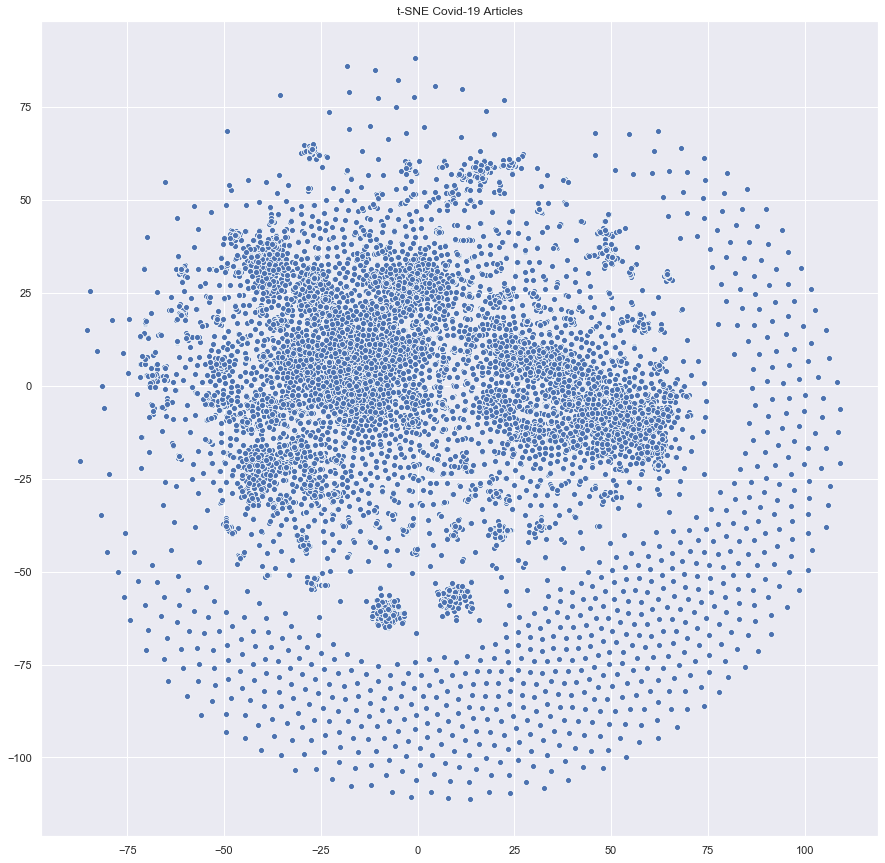

In [48]:
#plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette = palette)

plt.title("t-SNE Covid-19 Articles")
plt.show()

# Unsupervised Learning: Clustering w/ K-Means

In [49]:
from sklearn.cluster import KMeans

In [50]:
k = 10
kmeans = KMeans(n_clusters = k, n_jobs = 4, verbose = 10)
y_pred = kmeans.fit_predict(X_train)

In [51]:
y_train = y_pred

In [52]:
y_test = kmeans.predict(X_test)

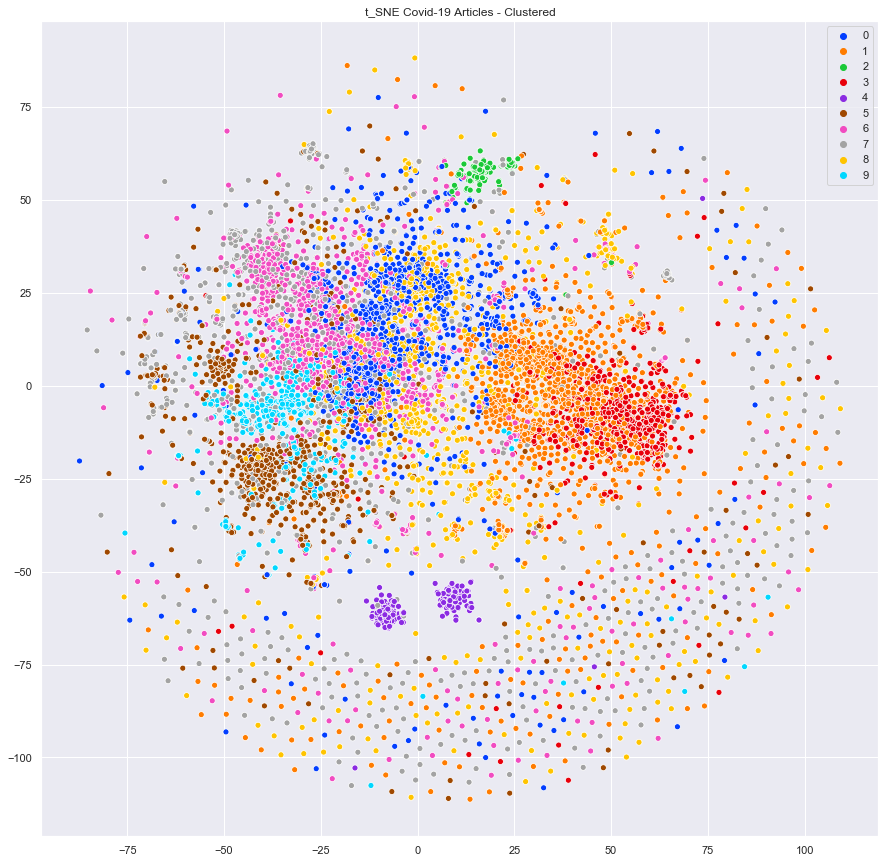

In [53]:
#sns settings
sns.set(rc={'figure.figsize':(15,15)})

#colors
palette = sns.color_palette("bright", len(set(y_pred)))

#plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend = 'full', palette = palette)
plt.title("t_SNE Covid-19 Articles - Clustered")
plt.show()

In [ ]:
a

In [ ]:
https://www.kaggle.com/maksimeren/covid-19-literature-clustering